# Indonesian Fake News Headline Topic Modeling w/ LDA (Latent Dirichlet Allocation) <a class="anchor" name="chapter0"></a>

### Table of Contents
* [Introduction](#chapter1)
* [Conclusion / Result](#chapter2)
* [Data Preparation](#chapter3)
* [Preprocessing & Visualization](#chapter4)
* [Modeling & Evaluation](#chapter5)
  * [LDA + BoW](#section_5_1)
  * [LDA + TF-IDF](#section_5_2)
  * [BERT + HDBSCAN](#section_5_3)

### Introduction / Motivation <a class="anchor" name="chapter1"></a>
Internet is a place used by almost all citizens in the world to search news articles, including Indonesian citizens. Because of the ease of accessing the internet, it is often used as a place to spread fake news. Those fake news has titles that can deceive people to read it (clickbait) by writing about hot topics or famous figures such as religion issues or figures like president. Based on these titles, this notebook will conduct topic modeling to see which topics are often made into fake news.

### About the data
This project used scraped data from [TurnBackHoax.id](https://turnbackhoax.id/) using BeatifulSoup by running `news.py`. TurnBackHoax.ID is a site managed by the Indonesian anti-hoax forum (MAFINDO). Data was collected from July 31, 2015 to June 26, 2022 with a total of about 9 thousand data and 2 columns (`title` and `label`).

### Goal
Goal of this project is to see which topics that are often made into fake news using LDA model and BERT model (Transformer). The model will produce a different number of topics, as for LDA model will be evaluated using coherence score.

##### **Why use coherence score?**
Coherence score can be used to measure how interpretable the topics are to humans. The topics are represented as the top N words with the highest probability that those words are related to that particular topic. However, there will be also analysis for several topics generated by model based on human judgement.

### Conclusion / Result <a class="anchor" name="chapter2"></a>
LDA model was able to be fitted with two different corpus, Bag of Words corpus and TF-IDF corpus. LDA + BoW model produces a coherence score of 0.58 with total 14 topics. While LDA + TF-IDF model produces higher coherence score of 0.63 with the more number of topics, which is 18 topics in total. As for BERT, the model produces ~60 topics. The result of the 3 model are presented below in the form of a table:

|Model|Number of Topics|
|:---:|:---:|
|LDA + BoW|16|
|LDA + TF-IDF|16|
|BERT + UMAP + HDBSCAN|60|

By looking at table above, based on the coherence score it is shown that LDA + TF-IDF fits better than LDA + BoW model. However, after manualy analyzing the results, LDA + BoW model have better distribution of topics because there are fewer overlapping topics ([here](#bow)). As for LDA + TF-IDF model, only two topics that are not overlapping each other while the other 15 topics are overlapping ([here](#tfidf)). Even though BERT model produces far more topics than other two LDA models, it is shown that for the top 5 topics generated have more diversity ([here](#bert)). </br>
Generally, by looking at most dominant document for each topics, all three models can cluster fake news headline into several topics.


[Back to Table of Contents](#chapter0)

# Data Preparation <a class="anchor" name="chapter3"></a>

Import library

In [1]:
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

In [3]:
df = pd.read_csv("/content/drive/MyDrive/headline_data.csv")
df.head(5)

,title,label
0,Anies Baswedan Menandatangani Kontrak untuk P...,SALAH
1,Orang Cina SIAP Perang dengan Pribumi dengan ...,SALAH
2,China Meluncurkan Matahari Buatan,SALAH
3,Anies Baswedan di Cover Majalah Al Islam Wuju...,SALAH
4,Foto Jokowi Memangku Wanita Berbikini di Pantai,SALAH


Show dataset info

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9139 entries, 0 to 9138
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   9139 non-null   object
 1   label   9139 non-null   object
dtypes: object(2)
memory usage: 142.9+ KB


In [5]:
df.shape

(9139, 2)

Check if there is missing value somewhere in dataset.

In [6]:
df.isna().any()

title    False
label    False
dtype: bool

Count each class value

In [7]:
df.label.value_counts()

SALAH            6824
HOAX              666
BENAR             432
KLARIFIKASI       358
DISINFORMASI      268
BERITA            183
FALSE             122
EDUKASI            82
Top                34
FITNAH             34
HASUT              29
MISINFORMASI       19
ISU                15
ACARA              15
HOAKS              13
INFORMASI           6
CLARIFICATION       5
Hoax                3
Admin               3
Cek                 2
Facebook            2
DOKUMENTASI         2
Misinformasi        1
Disinformasi        1
Benar               1
SCAM                1
FRAMING             1
EVENT               1
INFO                1
EVENTS              1
Campuran            1
Kompilasi           1
Siaran              1
Pemprov             1
Kementerian         1
Isu                 1
RILIS               1
Topik               1
Live                1
CekFakta            1
Klarifikasi         1
UPDATE              1
KOREKSI             1
FAKTA               1
Name: label, dtype: int64

From the above results it can be seen that there are some data labeled as "false", "*salah*" (false), and/or "hoax"/"*hoaks*". These 3 label actually have same meaning, namely fake or hoax.

Change "*hoaks*", "false" and "*salah*" (false) label into "hoax" label.

In [8]:
df["label"] = df["label"].apply(str.lower)
df["label"] = np.where(df["label"]=="hoaks", "hoax", df["label"])
df["label"] = np.where(df["label"]=="false", "salah", df["label"])
df["label"] = np.where(df["label"]=="salah", "hoax", df["label"])
df.label.value_counts()

hoax             7628
benar             433
klarifikasi       359
disinformasi      269
berita            183
edukasi            82
top                34
fitnah             34
hasut              29
misinformasi       20
isu                16
acara              15
informasi           6
clarification       5
admin               3
facebook            2
cek                 2
dokumentasi         2
scam                1
info                1
framing             1
events              1
campuran            1
siaran              1
cekfakta            1
pemprov             1
kementerian         1
live                1
topik               1
koreksi             1
kompilasi           1
rilis               1
event               1
update              1
fakta               1
Name: label, dtype: int64

Data that will be used for model later is data with "hoax" label only.

Check for duplicated data and drop duplicated rows

In [9]:
df[df.duplicated()].shape

(44, 2)

In [10]:
df.drop_duplicates(inplace=True, keep="first")
df.shape

(9095, 2)

Take only "hoax" labeled data and show new dataset info.

In [11]:
title_df = df[(df == "hoax").any(axis=1)]
title_df = title_df.drop(["label"], axis=1)
title_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7590 entries, 0 to 9138
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   7590 non-null   object
dtypes: object(1)
memory usage: 118.6+ KB


In [12]:
transformer_df = title_df.copy()

[Back to Table of Contents](#chapter0)

# Preprocessing & Visualization <a class="anchor" name="chapter4"></a>

Import required library.

In [13]:
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Install pysastrawi for stemming and additional stopword list for Indonesian words.

In [14]:
!pip install pysastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Create stopword remover

In [15]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
factory = StopWordRemoverFactory()
STOPWORDS_2 = factory.create_stop_word_remover()

Join list of indonesian stopwords from nltk, pysastrawi, and some additional words.

In [16]:
STOPWORDS = set(stopwords.words("indonesian"))
second_list = ('baiknya', 'berkali', 'kurangnya', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya')
STOPWORDS = STOPWORDS.union(STOPWORDS_2.dictionary.words, second_list)

Create a function to stem and remove stopwords from text.

In [17]:
def text_stemmer(text: str):
    stem = []
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    word_token = word_tokenize(text)
    stemmed = [stemmer.stem(word) for word in word_token]
    stem = ' '.join(stemmed)
    return stem

Create a function to tokenize words from title.

In [18]:
from gensim.utils import simple_preprocess
def tokenizer(text):
    result = []
    for token in simple_preprocess(text):
      result.append(token)
    return result

Apply stemmer and stopword remover to dataset.

In [19]:
title_df["title"] = title_df["title"].apply(text_stemmer)

Take a look of dataset after some cleaning.

In [20]:
title_df.head(5)

,title
0,anies baswedan menandatangani kontrak pimpin j...
1,cina perang pribumi senjata replika
2,china luncur matahari buat
3,anies baswedan cover majalah al islam wujud ja...
4,foto jokowi memang wanita bikin pantai


Checking again if there is another duplicated title and then drop duplicated data.

In [21]:
title_df[title_df["title"].duplicated()].shape

(24, 1)

In [22]:
title_df["title"].drop_duplicates(inplace=True, keep="first")
title_df.shape

(7590, 1)

**Generate wordcloud for headline news**

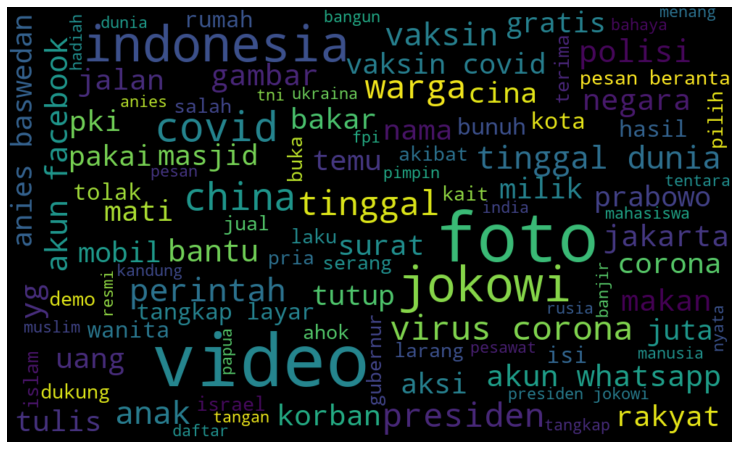

In [23]:
headline_text = title_df["title"]
headline_text = " ".join(headline_text.to_list())
headline_text_wordcloud = WordCloud(width=1000,
                                    height=600,
                                    max_font_size=100,
                                    max_words=100,
                                    background_color="black").generate(headline_text)
plt.figure(figsize=(15,8))
plt.imshow(headline_text_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

As we can see that after stemming and removing stopwords from data, some common word is "**video**", **"*foto*"** (photo), "**jokowi**" (Indonesia current president), etc as shown picture above.

Next we generate histogram of headline news word lengths.

In [24]:
headline_visualization = title_df.copy()
headline_visualization["num_word"] = title_df["title"].apply(lambda x: len(str(x).split()))

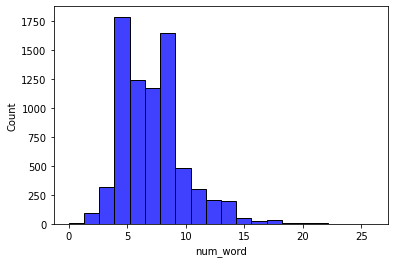

In [25]:
sns.histplot(data=headline_visualization, x="num_word", bins=20, color="blue")

As shown from graph above, most of headline news have 5 to 10 words.

Bellow we look for 20 most common words that appear in news headline.

In [26]:
headline_visualization["word_list"] = headline_visualization["title"].apply(lambda x: str(x).split())
common_words = Counter([item for sublist in headline_visualization["word_list"] for item in sublist])
temp = pd.DataFrame(common_words.most_common(20))
temp.columns = ["common_words", "count"]
temp.style.background_gradient(cmap="Blues")

,common_words,count
0,video,829
1,foto,751
2,covid,450
3,jokowi,445
4,19,421
5,indonesia,381
6,akun,316
7,tinggal,272
8,vaksin,256
9,corona,256


Next we create tokenized data by applying `tokenizer` function.

In [27]:
tokenized_data = title_df["title"].map(tokenizer)

Create dictionary from tokenized data.

In [28]:
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, TfidfModel
from pprint import pprint
import gensim

id2word = Dictionary(tokenized_data)

[Back to Table of Contents](#chapter0)

# Modeling & Evaluation <a class="anchor" name="chapter5"></a>
---

## Latent Dirichlet Allocation (LDA) 

LDA is a generative probabilistic model that tries to find groups of words that appears frequently together across different documents. These frequently appearing words represent our topics, assuming that each document is a mixture of different words.

Here we create a function that will return list of LDA model and it's corresponding coherence value.

In [29]:
def model_and_evaluate(dictionary, corpus, texts, start = 1, stop = 11, step = 1):
  model_list = []
  coherence_val = []
  for i in range(start, stop, step):
    lda_model = LdaMulticore(corpus=corpus,
                            id2word=dictionary,
                            num_topics=i,
                            random_state=42,
                            chunksize=100,
                            passes=5,
                            alpha=.1,
                            eta=.1)
    model_list.append(lda_model)
    coherence_lda_model = CoherenceModel(model=lda_model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence="c_v")
    coherence_lda = coherence_lda_model.get_coherence()
    coherence_val.append(coherence_lda)
  print(f"Done.")
  return model_list, coherence_val

### Bag of Words Model <a class="anchor" name="section_5_1"></a>

**Bag of words** or **BoW** is a model that will allow us to represent text as numerical feature vectors. Idea behind bag of words is quite simple, we create a vocabulary of unique tokens which we already did (`tokenized_data`) and then construct feature vector from each document that contain the counts of how often each words occurs in the particular document.

Here we create bag of words model from dictionary and see results of converting words from dictionary to numbers.

In [30]:
bow_corpus = [id2word.doc2bow(text) for text in tokenized_data]
texts = tokenized_data
print(bow_corpus[:1][0][:5])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


Here we are using topics number starting from 2 topics until 18 topics with increase of 2 topics each step.

In [31]:
start = 2
stop = 20
step = 2
bow_model_list, bow_coherence_val = model_and_evaluate(id2word, bow_corpus, texts, start, stop, step)

Done.


After fitting and coherence calculation done, next we plot coherence score for each *N*-number of topics.

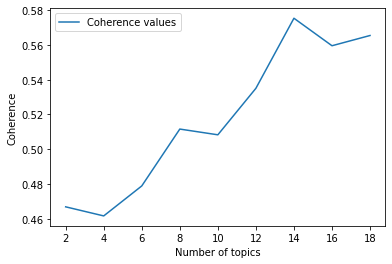

In [32]:
x = range(start, stop, step)
plt.plot(x, bow_coherence_val, label=("Coherence values"))
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(loc="best")
plt.show()

As we can see from graph above, for this bag of words model that as the number of topic increases, the coherence score will also increases. Also it looks like that the coherence score can still improved by increasing number of topic. However, after fitting the model several times with different number of topics (with max. 50 topics), it is true that for this case the coherence score will also increase but that is also because there are repeated keywords in those topics. This is confirmed by plotting the result using pyLDAvis library bellow.

After training process is complete, the number of topics with the highest coherence value is 14 topics. Bellow is shown each topic with top 5 keywords of each topic.

In [33]:
from collections import OrderedDict
index = bow_coherence_val.index(max(bow_coherence_val))
bow_best_model = bow_model_list[index]
print(f"Topic: {bow_best_model.num_topics}\nCoherence score: {max(bow_coherence_val)}")
my_dict = OrderedDict({f'Topic {i}': [token for token, score in bow_best_model.show_topic(i, topn=5)] for i in range(0, bow_best_model.num_topics)})
for k, v in my_dict.items():
  print(k, v)

Topic: 14
Coherence score: 0.5753733698736495
Topic 0 ['tulis', 'mati', 'jual', 'poster', 'pilpres']
Topic 1 ['ahok', 'jakarta', 'bakar', 'masjid', 'uang']
Topic 2 ['tinggal', 'dunia', 'sebab', 'bank', 'kena']
Topic 3 ['pt', 'kpu', 'mobil', 'undang', 'turun']
Topic 4 ['kandung', 'kanker', 'israel', 'foto', 'demo']
Topic 5 ['prabowo', 'tni', 'menang', 'sandi', 'video']
Topic 6 ['anak', 'al', 'virus', 'foto', 'hasut']
Topic 7 ['pki', 'video', 'china', 'polisi', 'nama']
Topic 8 ['papua', 'air', 'larang', 'indonesia', 'pimpin']
Topic 9 ['muslim', 'pesan', 'kota', 'akun', 'beranta']
Topic 10 ['jokowi', 'aksi', 'dukung', 'foto', 'presiden']
Topic 11 ['cina', 'gratis', 'bahaya', 'tentara', 'warga']
Topic 12 ['surat', 'islam', 'edar', 'rumah', 'serta']
Topic 13 ['makan', 'palsu', 'salah', 'kampanye', 'sandiaga']


To visualize distribution of each topic better, here we are using pyLDAvis to plot all the topics. 

In [34]:
!pip install pyldavis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import pyLDAvis, json
from pyLDAvis.gensim_models import prepare
from pyLDAvis import PreparedData

pyLDAvis.enable_notebook(local=True)

def prepared_data_from_dict(vis_data):
    topic_coordinates = pd.DataFrame.from_dict(vis_data['mdsDat'])
    topic_info = pd.DataFrame.from_dict(vis_data['tinfo'])
    token_table = pd.DataFrame.from_dict(vis_data['token.table'])
    R = vis_data['R']
    lambda_step = vis_data['lambda.step']
    plot_opts = vis_data['plot.opts']
    client_topic_order = vis_data['topic.order']

    return PreparedData(topic_coordinates, topic_info,
                        token_table, R, lambda_step, plot_opts, client_topic_order)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [36]:
lda_display = prepare(bow_best_model, bow_corpus, id2word, sort_topics = False)
pyLDAvis.save_json(lda_display, "lda_bow.json")

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Each topic is represented by a circle, select one circle to see more details. <a class="anchor" name="bow"></a>

In [37]:
filename = "/content/lda_bow"

with open(filename + '.json', 'r') as json_file:
    dict_data = json.load(json_file)
    viz_data = prepared_data_from_dict(dict_data)
pyLDAvis.display(viz_data)

Based on the above visualization, even though this is the best model based on the coherence score we can see that ther is a lot of topics that is overlapping each other. This is because as mentioned before, there are repeated keywords. There are only few topics that don't overlap each other like `Topic 2`, `Topic 11`, and `Topic 13`. 

[Back to Table of Contents](#chapter0)

#### Topic 2
---

Top 5 keywords: 'ahok'(Former Governor of Jakarta), 'jakarta'(Capital of Indonesia), 'bakar'(burn), 'masjid'(mosque), and 'uang'(money). </br>
From top 5 keywords, topic 2 discusses about *politics and religion*.

#### Topic 11
---

Top 5 keywords: 'jokowi'(current president of Indonesia), 'aksi'(action), 'dukung'(support), 'foto'(photo), 'presiden'(president). </br>
From top 5 keywords, topic 11 discusses about *politics*.

#### Topic 13
---

Top 5 keywords: 'surat'(letter), 'islam', 'edar'(share), 'rumah'(house), 'serta'(join). </br>
From top 5 keywords, topic 13 might be discusses about *religion*.

[Back to Table of Contents](#chapter0)

### TF-IDF model <a class="anchor" name="section_5_2"></a>
---

Next one is **Term Frequency-Inverse Document Frequency** or **TF-IDF**. When we analyzing text data, we often encounter words that occur accross multiple title. These frequently occurring words typically don't contain useful information. TF-IDF can be used to downweight these frequently occurring words in feature vectors.

Convert the Bag of Words corpus into TF-IDF corpus.

In [44]:
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]
tfidf_model_list, tfidf_coherence_val = model_and_evaluate(id2word, tfidf_corpus, texts, start, stop, step)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

Done.


Plot the coherence score for each *N* number of topics.

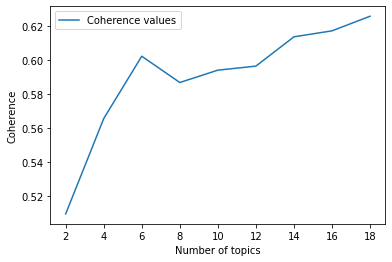

In [45]:
x = range(start, stop, step)
plt.plot(x, tfidf_coherence_val, label=("Coherence values"))
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(loc="best")
plt.show()

Show topic number, coherence score, and each topics top 5 keywords.

In [46]:
from collections import OrderedDict
tfidf_index = tfidf_coherence_val.index(max(tfidf_coherence_val))
tfidf_best_model = tfidf_model_list[tfidf_index]
print(f"Topic: {tfidf_best_model.num_topics}\nCoherence score: {max(tfidf_coherence_val)}")
tfidf_dict = OrderedDict({f'Topic {i}': [token for token, score in tfidf_best_model.show_topic(i, topn=5)] for i in range(0, tfidf_best_model.num_topics)})
for k, v in tfidf_dict.items():
  print(k, v)

Topic: 18
Coherence score: 0.6258277624521518
Topic 0 ['warga', 'sunting', 'rohingya', 'daftar', 'poster']
Topic 1 ['bakar', 'pesan', 'gratis', 'hasil', 'beranta']
Topic 2 ['logo', 'serta', 'pilih', 'turun', 'april']
Topic 3 ['tinggal', 'muslim', 'raja', 'dunia', 'saudi']
Topic 4 ['prabowo', 'bahaya', 'sandi', 'tol', 'resmi']
Topic 5 ['makan', 'sebab', 'jual', 'rakyat', 'mati']
Topic 6 ['kandung', 'culi', 'tangkap', 'narkoba', 'permen']
Topic 7 ['ahok', 'indonesia', 'sakit', 'rizieq', 'pilpres']
Topic 8 ['air', 'al', 'tentara', 'salah', 'ribu']
Topic 9 ['pki', 'nama', 'cina', 'kota', 'palsu']
Topic 10 ['dukung', 'jokowi', 'anak', 'presiden', 'israel']
Topic 11 ['menang', 'babi', 'tanam', 'tolak', 'tangan']
Topic 12 ['edar', 'korban', 'kpu', 'salman', 'rumah']
Topic 13 ['islam', 'polisi', 'papua', 'milik', 'lowong']
Topic 14 ['aksi', 'jakarta', 'jalan', 'masjid', 'tulis']
Topic 15 ['fitnah', 'djarot', 'kpk', 'hasut', 'komunis']
Topic 16 ['china', 'tni', 'pakai', 'angkat', 'corona']
Topi

By using TF-IDF corpus, LDA model generate more number of topics and higher coherence score compared to same model that use bag of words corpus.

Visualize distribution of each topic. <a class="anchor" name="tfidf"></a>

In [47]:
tfidf_lda_display = prepare(tfidf_best_model, tfidf_corpus, id2word, sort_topics = False)
pyLDAvis.save_json(tfidf_lda_display, "lda_tfidf.json")

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [48]:
filename = "/content/lda_tfidf"

with open(filename + '.json', 'r') as json_file:
    dict_data = json.load(json_file)
    viz_data = prepared_data_from_dict(dict_data)
pyLDAvis.display(viz_data)

Even though model with TF-IDF corpus generate more topics with higher coherence score, it is shown from above visualisation that only 3 topics that are not overlapping with another topics, which is `Topic 8`, `Topic 10`, and `Topic 11`. The same reason is also applied here because there are a lot of repeated keywords on these topics and these keywords are also in the top 10 to top 5 keywords. We can see this by choose one of the overlapping topics and see the distribution of each keywords.

[Back to Table of Contents](#chapter0)

#### Topic 8
---

Top 5 keywords: 'ahok'(Former Governor of Jakarta), 'indonesia', 'sakit'(sick), 'rizieq'(leader of Islamic Defenders Front), 'pilpres'(presidential election). </br>
From top 5 keywords, topic 8 discusses about *politics and religion*.

#### Topic 10
---

Top 5 keywords: 'pki'(Communist Party of Indonesia), 'nama'(name), 'cina'(China), 'kota'(city/town), 'palsu'(fake/false). </br>
From top 5 keywords, Top 10 possibly contains titles about *politics*.

#### Topic 11
---

Top 5 keywords: 'dukung'(support), 'jokowi'(Current president of Indonesia), 'anak'(children), 'presiden'(president), 'israel'. </br>
From top 5 keywords, Top 11 possibly contains titles about *politics and social* problem.

[Back to Table of Contents](#chapter0)

## Bidirectional Encoder Representations from Transformers (BERT) <a class="anchor" name="section_5_3"></a>

In [53]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[Back to Table of Contents](#chapter0)

Here we are using `distilbert`.

In [54]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("distilbert-base-nli-mean-tokens")

Create word embeddings using `distilbert` model.

In [55]:
embeddings = model.encode(transformer_df["title"].to_list(), show_progress_bar=True)

Batches:   0%|          | 0/238 [00:00<?, ?it/s]

In [56]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Using `umap` library to to reduce embeddings dimension into 5 while keeping the size of the local neighborhood at 15.

In [57]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric="cosine").fit_transform(embeddings)

Streaming output truncated to the last 5000 lines.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprec

In [58]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


After reduced the embeddings dimensionality to 5, we can cluster the data using `HDBSCAN`. `HDBSCAN` does not force data to some clusters if it considers them as an outliers.

In [59]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric="euclidean",
                          cluster_selection_method="eom").fit(umap_embeddings)

Visualize the cluster and reduce the dimensionality into 2.

/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
/usr/local/lib/python3.7/dist-packages/numba/core/ir_util

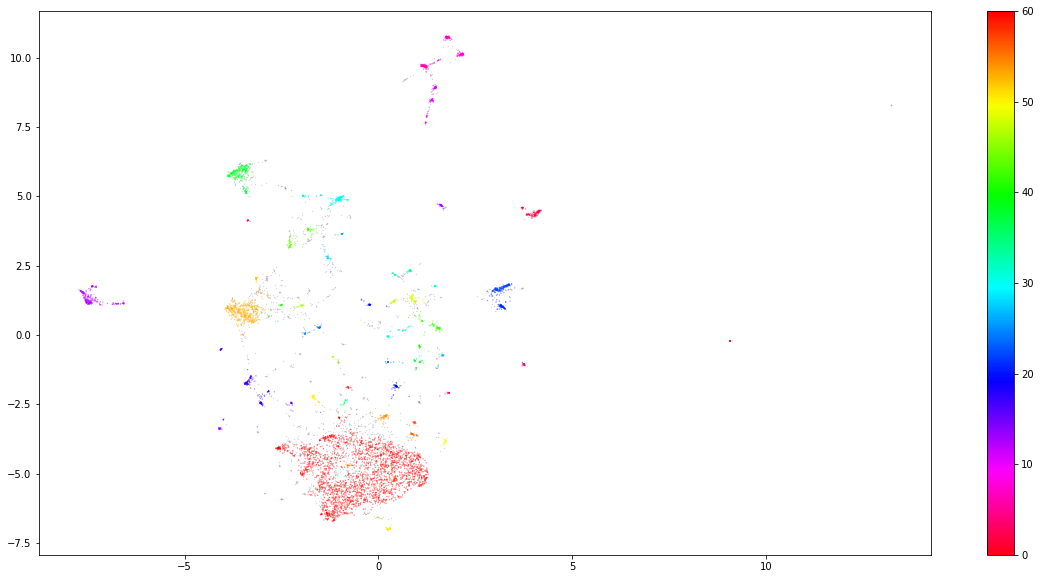

In [60]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

From the visualization above, it can be seen that number of topics generated is up to 60 and because of that it is difficult to identify individual clusters.

Create a single document for each cluster of documents.

In [61]:
transformer_df["topic"] = cluster.labels_
transformer_df["doc_id"] = range(len(transformer_df))
title_per_topic = transformer_df.groupby(["topic"], as_index = False).agg({"title": " ".join})

Create a function to calculate **c-TF-IDF**. **c-TF-IDF** is a class based TF-IDF where all data in the same cluster treated as a single data itself and then apply TF-IDF.

In [62]:
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=STOPWORDS).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(title_per_topic.title.values, m=len(transformer_df))

Here we create function to show number of titles belong to certain topics and function to show top *N* words each topics.

In [63]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['topic'])
                     .title
                     .count()
                     .reset_index()
                     .rename({"topic": "topic", "title": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, title_per_topic, n=20)
topic_sizes = extract_topic_sizes(transformer_df)
topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,topic,Size
61,60,2400
0,-1,1659
54,53,447
13,12,246
39,38,242
23,22,177
31,30,171
3,2,125
7,6,123
18,17,96


[Back to Table of Contents](#chapter0)

Topic with `-1` value refers to all titles that did not have any topics assigned which means that all these titles are considered as an outlier.

From the result above we can see that `Topic 60`, `Topic 53`, `Topic 12` `Topic 38`, and `Topic 22` are the top 5 largest cluster model can found. Below we can show the words belonging to those topics.

#### Topic 60 <a class="anchor" name="bert"></a>
---

In [64]:
top_n_words[60][:5]

[('foto', 0.04433948174003838),
 ('jokowi', 0.03402056739463456),
 ('meninggal', 0.029079914780269115),
 ('dunia', 0.022120548219899835),
 ('anak', 0.018918309255206916)]

Top 5 keywords: foto(photo), jokowi(current President of Indonesia), meninggal(death), dunia(world), and anak(children). </br>
Keywords *meninggal* and *dunia* actually can be combine into one word, *meninggal dunia* (death) so this is actually still count as one words. From top 5 keywords for topic 60 is might be related to *politic and social*. 

#### Topic 53
---

In [65]:
top_n_words[53][:5]

[('video', 0.30293567935077714),
 ('detik', 0.028883934977379018),
 ('jokowi', 0.026603772657981768),
 ('ukraina', 0.025133502853733277),
 ('pesawat', 0.025099405984697645)]

Top 5 keywords: video, detik(seconds), jokowi(current President of Indonesia), ukraina, and pesawat(plane). </br>
From top 5 keywords, topic 53 discusses about *politics and military*.

#### Topic 12
---

In [66]:
top_n_words[12][:5]

[('facebook', 0.3156152161655094),
 ('akun', 0.2878338840726876),
 ('bupati', 0.1022964069958329),
 ('instagram', 0.08933183717881847),
 ('twitter', 0.085080590088635)]

Top 5 keywords: facebook, akun(account), bupati(regent), instagram, and twitter. </br>
From top 5 keywords, topic 12 is clearly about *social media and governtment officials*.

#### Topic 38
---

In [67]:
top_n_words[38][:5]

[('19', 0.3720383385351273),
 ('covid', 0.3649960042959907),
 ('vaksin', 0.09798375274804325),
 ('positif', 0.04848630219436668),
 ('pasien', 0.042627761242310463)]

Top 5 keywords: 19, covid, vaksin(vaccine), positif(positive), and pasien(patient). </br>
From top 5 keywords we can se clearly *covid-19* as a topic.

#### Topic 22
---

In [68]:
top_n_words[22][:5]

[('indonesia', 0.4566042348762706),
 ('cina', 0.047415683990918785),
 ('garuda', 0.04037167913208583),
 ('pt', 0.03529616463375253),
 ('jokowi', 0.033455076861944474)]

Top 5 keywords: indonesia, cina(china), garuda(Indonesian airlines), pt(public company), and jokowi(current president of Indonesia). </br>
From top 5 keywords, topic 22 discusses about some *economy* related.

[Back to Table of Contents](#chapter0)